In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pylab as plt
% matplotlib inline
% load_ext autoreload
% autoreload 2

In [2]:
tf.__version__

'1.3.0'

In [46]:
from modules.spectral_pool_test import max_pool
from modules.spectral_pool import spectral_pool
from modules.frequency_dropout import test_frequency_dropout
from modules.create_images import open_image, downscale_image

In [47]:
image = open_image('aj.jpg')
grayscale_image = np.asarray(downscale_image(image, 256, 256).convert('F')) / 255.
image = downscale_image(image, 256, 256).convert('RGB')
image = np.asarray(image) / 255.

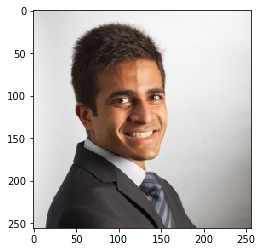

In [48]:
# original image
plt.imshow(image, cmap='gray')

In [49]:
def get_fft_plot(fft, shift_channel=True, eps=1e-12, pad_to_width=256):
    """ Convert a fourier transform returned from tensorflow in a format
    that can be plotted.
    Args:
        fft: numpy array with image and channels
        shift_channel: if True, the channels are assumed as first dimension and
                       will be moved to the end.
        eps: to be added before taking log
    """
    if shift_channel:
        fft = np.squeeze(np.moveaxis(np.absolute(fft), 0, -1))
    fft = np.log(fft + eps)
    mn = np.min(fft, axis=(0, 1))
    mx = np.max(fft, axis=(0, 1))
    fft = (fft - mn) / (mx - mn)
    
    fft_shifted = np.fft.fftshift(fft)
    padding = int((pad_to_width - fft_shifted.shape[1]) / 2)
    if padding < 0:
        padding = 0
    return np.pad(
        fft_shifted, 
        pad_width=padding,
        mode='constant',
        constant_values=1.,
    )


### Create Grid grayscale:

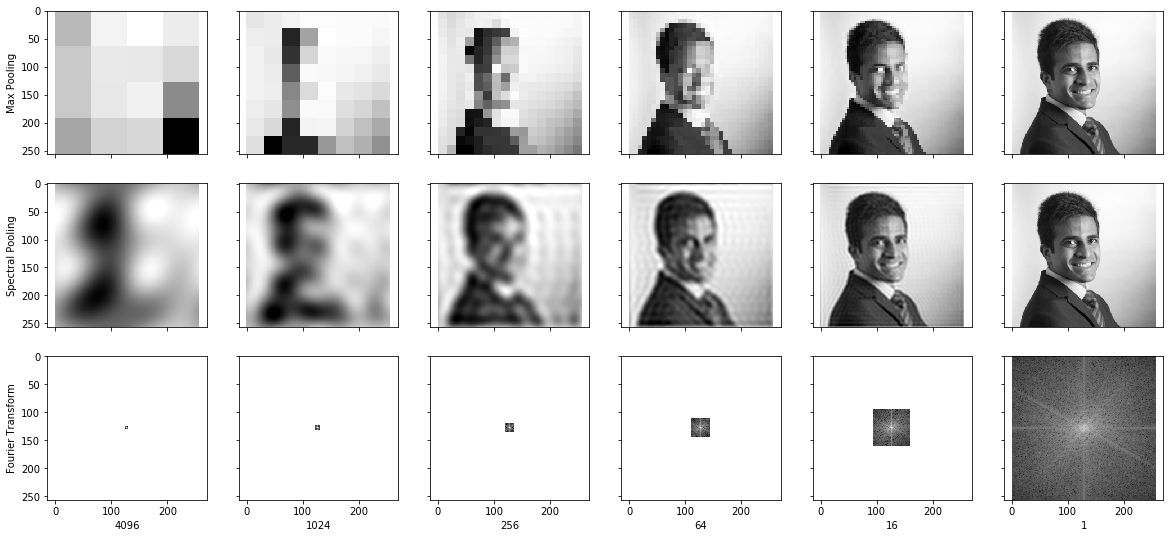

In [50]:
fig, axes = plt.subplots(3, 6, figsize=(20, 9), sharex=True, sharey=True)
pool_size = [64, 32, 16, 8, 4, 1]
grayscale_images = np.expand_dims(
    np.expand_dims(grayscale_image, 0), 0
)   

for i in range(6):
    ax = axes[0, i]
    im_pool = max_pool(image, pool_size=pool_size[i])
    im_pool = np.squeeze(im_pool)
    ax.imshow(im_pool, cmap='gray')
    if not i:
        ax.set_ylabel('Max Pooling')

for i in range(6):
    ax = axes[1, i]
    ax2 = axes[2, i]
    cutoff_freq = int(256 / (pool_size[i] * 2))
    tf_cutoff_freq = tf.cast(tf.constant(cutoff_freq), tf.float32)
    im_pool = test_frequency_dropout(grayscale_images, tf_cutoff_freq)[0]
    im_pool = np.clip(np.squeeze(im_pool), 0, 1)
    im_fft, _ = spectral_pool(
        grayscale_images,
        filter_size=(1 + 2 * cutoff_freq),
        return_transformed=True
    )
    ax.imshow(im_pool, cmap='gray')
    ax2.imshow(get_fft_plot(im_fft[0]), cmap='gray')
    ax2.set_xlabel(pool_size[i]**2)
    if not i:
        ax.set_ylabel('Spectral Pooling')
        ax2.set_ylabel('Fourier Transform')

### Create Grid RGB:

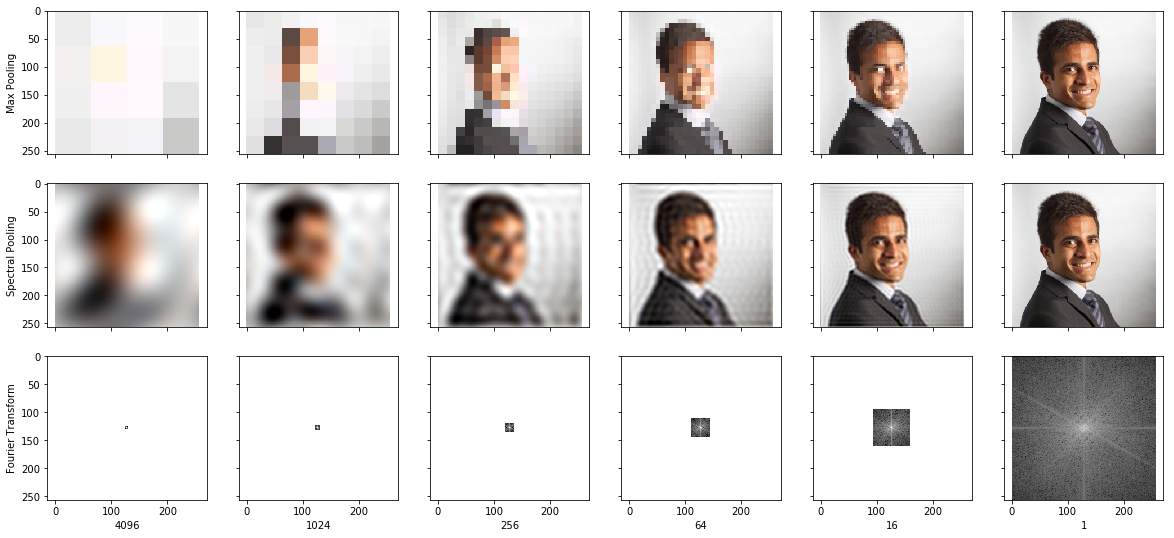

In [59]:
fig, axes = plt.subplots(3, 6, figsize=(20, 9), sharex=True, sharey=True)
pool_size = [64, 32, 16, 8, 4, 1]

for i in range(6):
    ax = axes[0, i]
    im_pool = max_pool(image, pool_size=pool_size[i], convert_grayscale=False)
    im_pool = np.squeeze(im_pool)
    ax.imshow(im_pool, cmap='gray')
    if not i:
        ax.set_ylabel('Max Pooling')

for i in range(6):
    ax = axes[1, i]
    ax2 = axes[2, i]
    cutoff_freq = int(256 / (pool_size[i] * 2))
    tf_cutoff_freq = tf.cast(tf.constant(cutoff_freq), tf.float32)
    im_pool = test_frequency_dropout(
        np.expand_dims(np.moveaxis(image, -1, 0), 0),
        tf_cutoff_freq
    )[0]
    im_pool = np.clip(np.squeeze(im_pool), 0, 1)
    im_fft, _ = spectral_pool(
        grayscale_images,
        filter_size=(1 + 2 * cutoff_freq),
        return_transformed=True
    )
    ax.imshow(np.moveaxis(im_pool, 0, -1), cmap='gray')
    ax2.imshow(get_fft_plot(im_fft[0]), cmap='gray')
    ax2.set_xlabel(pool_size[i]**2)
    if not i:
        ax.set_ylabel('Spectral Pooling')
        ax2.set_ylabel('Fourier Transform')